In [1]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
import umap.umap_ as umap

from modules import processor

In [2]:
pd.set_option('display.max_colwidth', None)
PATH = '/Users/kaledinaoa/data/data_sber_market_test_ml/'

raw_data = processor.load_csv("train", PATH)
sample_sumbission = processor.load_csv("sample_submission", PATH)

In [3]:
main_df = raw_data.copy()
raw_data.head(1)

,user_id,order_completed_at,cart
0,2,2015-03-22 09:25:46,399


In [4]:
# беру для трейна последнюю дату
def split_to_train_test_last_day(df):
        
        date_column = 'order_completed_at'
        
        df_clean_sorted = df.sort_values(by=['user_id', date_column])
        grouped_df = df_clean_sorted.groupby('user_id')

        train_data = []
        test_data = []

        for user_id, group_df in grouped_df:
            # Получаем последнюю дату для данного пользователя
            last_date = group_df[date_column].max()
            # Выбираем все записи кроме последней даты для обучающего набора
            train_data.append(group_df[group_df[date_column] != last_date])
            # Выбираем все записи на последнюю дату для тестового набора
            test_data.append(group_df[group_df[date_column] == last_date])

        train_df = pd.concat(train_data)
        test_df = pd.concat(test_data)

        return train_df, test_df

train_df, test_df = split_to_train_test_last_day(main_df)

In [5]:
# some info about test/train split
def print_df_info(df, id='user_id', tr='order_completed_at', cart="cart"):
    users, items, interactions = df[id].nunique(), df[tr].nunique(), df.shape[0]
    carts = df[cart].nunique()
    str = """users: {us:5}, items: {it:5}, unique dates: {inter:7}, unique carts:{ca:4}""".format(us=users, it=items, inter=interactions, ca=carts)
    return str

print("raw_data:   ", print_df_info(raw_data))
print("train_df:   ", print_df_info(train_df))
print("test_df:    ", print_df_info(test_df))

raw_data:    users: 20000, items: 208155, unique dates: 3123064, unique carts: 881
train_df:    users: 20000, items: 188458, unique dates: 2841987, unique carts: 869
test_df:     users: 20000, items: 19923, unique dates:  281077, unique carts: 690


In [6]:
# user_item_matrix

user_item_matrix = pd.pivot_table(test_df, 
                                  index='user_id', columns='cart', 
                                  values='order_completed_at',
                                  aggfunc='count', 
                                  fill_value=0
                                 )
 
user_item_matrix = user_item_matrix.astype(float) 
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(3)


cart,0,1,2,4,5,6,7,8,9,10,...,870,871,872,874,875,876,877,878,879,880
user_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
count_unique_carts = test_df.cart.unique().shape[0]
count_unique_users = test_df.user_id.unique().shape[0]
count_unique_carts_tr = train_df.cart.unique().shape[0]
count_unique_users_tr = train_df.user_id.unique().shape[0]

print("test unique users  = ",count_unique_users)
print("train unique users = ",count_unique_users_tr)
print("test unique carts  = ",count_unique_carts)
print("train unique carts = ",count_unique_carts_tr)

# на трейне гораздо больше carts

test unique users  =  20000
train unique users =  20000
test unique carts  =  690
train unique carts =  869


### model ALS

In [8]:
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight

In [9]:
itemid_to_id, userid_to_id, id_to_itemid, id_to_userid = processor.some_ids_preparation_to_als(user_item_matrix)

In [30]:
%%time 

def building_model(factors):
    model_als = AlternatingLeastSquares(factors=factors, # скрытые факторы
                                    regularization=0.001, # регуляризация, от переобучения модели
                                    iterations=100, 
                                    calculate_training_loss=True)
    
    model_als.fit(csr_matrix(user_item_matrix).tocsr(), show_progress=True)
    return model_als

model_als = building_model(1000)

model = model_als

# MODEL INFORMATION
print('item_factors:', model.item_factors.shape)
print('user_factors:', model.user_factors.shape)

# эмбеддинги items
item_factors=pd.DataFrame(model.item_factors)

# эмбеддинги users
user_factors=pd.DataFrame(model.user_factors)
# user_factors.head(3)

reducer = umap.UMAP(n_components=2) # to 2-dimension
umap_embeddings_users = reducer.fit_transform(user_factors)
umap_embeddings_items = reducer.fit_transform(item_factors)

  0%|          | 0/100 [00:00<?, ?it/s]

item_factors: (690, 1000)
user_factors: (20000, 1000)
CPU times: user 2h 13min 32s, sys: 11min 51s, total: 2h 25min 23s
Wall time: 20min 54s


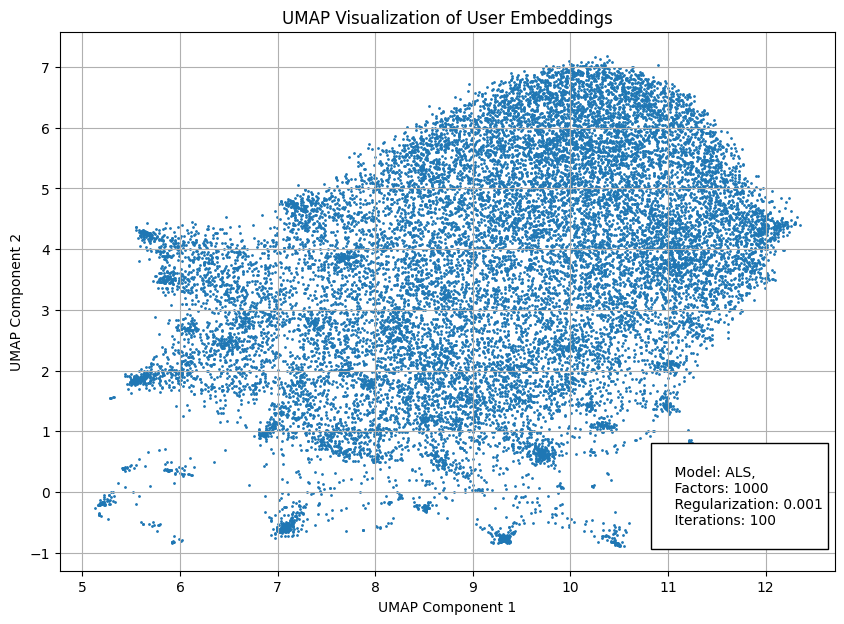

In [31]:
from modules import processor
processor.figure_umap_embeddings(model, umap_embeddings_users, 'UMAP Visualization of User Embeddings')

In [32]:
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import cosine_similarity
from modules import processor
from sklearn import metrics
import matplotlib.pyplot as plt

In [33]:
def figure_umap_embeddings(model_als, umap_emb, name):

        plt.figure(figsize=(10, 7))
        plt.scatter(umap_emb[:, 0], umap_emb[:, 1], s=10)  # Рассеиваем точки
        plt.title(name)  # Заголовок
        plt.xlabel('UMAP Component 1')  # Метка оси X
        plt.ylabel('UMAP Component 2')  # Метка оси Y
        plt.grid(True)  # Включаем сетку

        model_info = f"""
        Model: ALS, 
        Factors: {model_als.factors} 
        Regularization: {model_als.regularization}
        Iterations: {model_als.iterations}
        """
        
        # Добавление информации о модели в квадратике на графике
        if model_info:
            plt.text(0.77, 0.05, model_info, ha='left', va='bottom', transform=plt.gca().transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=1))
        
        # Определение save_path, чтобы избежать ошибки UnboundLocalError
        save_path = None

        if name == 'UMAP Visualization of User Embeddings':
            name = f"ALS_f{model_als.factors}_r{model_als.regularization}_i{model_als.iterations}"
            save_path = f'07_figures/UMAP_Users/{name}.png'

        # Сохранение графика в файл, если указан путь для сохранения
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')

        plt.show()

def print_clusters(X, labels, core_samples_mask,n_clusters_):
        size = 10
        s = 4
        plt.figure(figsize=(20, 10))

        # Black removed and is used for noise instead.
        unique_labels = set(labels)
        colors = [plt.cm.Spectral(each)
                for each in np.linspace(0, 1, len(unique_labels))]

        for k, col in zip(unique_labels, colors):
            # noize
            if k == -1:
                col = [0, 0, 0, 1]

            class_member_mask = (labels == k)
        
            xy = X[class_member_mask & core_samples_mask]
            if len(xy) > 0:
                centroid_x = xy[:, 0].mean()
                centroid_y = xy[:, 1].mean()
            else:
                centroid_x = 0
                centroid_y = 0
                
            xy = X[class_member_mask & core_samples_mask]
            plt.scatter(xy[:, 0], xy[:, 1], s=s, c=[col], label='Cluster %d' % k)

        
            # Добавляем метку кластера
            if k != -1:
                a=1
                centroid_x = xy[:, 0].mean()
                centroid_y = xy[:, 1].mean()
                xx=centroid_x
                yy=centroid_y+a
                plt.plot([centroid_x, xx], [centroid_y, yy], color='gray', linestyle='--')
                plt.text(xx, yy, str(k), fontsize=size, color='black',
                        bbox=dict(facecolor='white', edgecolor='black', boxstyle='square'))
            else:
                xy = X[class_member_mask & ~core_samples_mask]
                plt.scatter(xy[:, 0], xy[:, 1], s=s, c=[col])

        plt.title('Estimated number of clusters: %d' % n_clusters_)
        plt.show()
        pass

def compute_cosine_similarity(cluster_embeddings):
        similarity_matrix = cosine_similarity(cluster_embeddings)
        average_similarity = similarity_matrix.mean()
        return average_similarity

def print_dbscan(X, n_clusters):

        db = DBSCAN(eps=0.3, min_samples=n_clusters).fit(X)
        core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        core_samples_mask[db.core_sample_indices_] = True
        labels = db.labels_
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_ = list(labels).count(-1)

        cos_sim = {}

        for cluster_id in range(n_clusters_):
            cluster_points = X[labels == cluster_id]
            cos_sim[cluster_id] = compute_cosine_similarity(cluster_points)

        print(core_samples_mask)
        print('Estimated number of clusters: %d' % n_clusters_)
        print('Estimated number of noise points: %d' % n_noise_)
        print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))

        print_clusters(X, labels, core_samples_mask, n_clusters_)
        cos_sim_df = pd.DataFrame(list(cos_sim.items()), columns=['Cluster #', 'Cosine Similarity'])

        return labels, cos_sim_df, n_clusters_


[ True  True  True ...  True  True False]
Estimated number of clusters: 4
Estimated number of noise points: 9
Silhouette Coefficient: 0.076


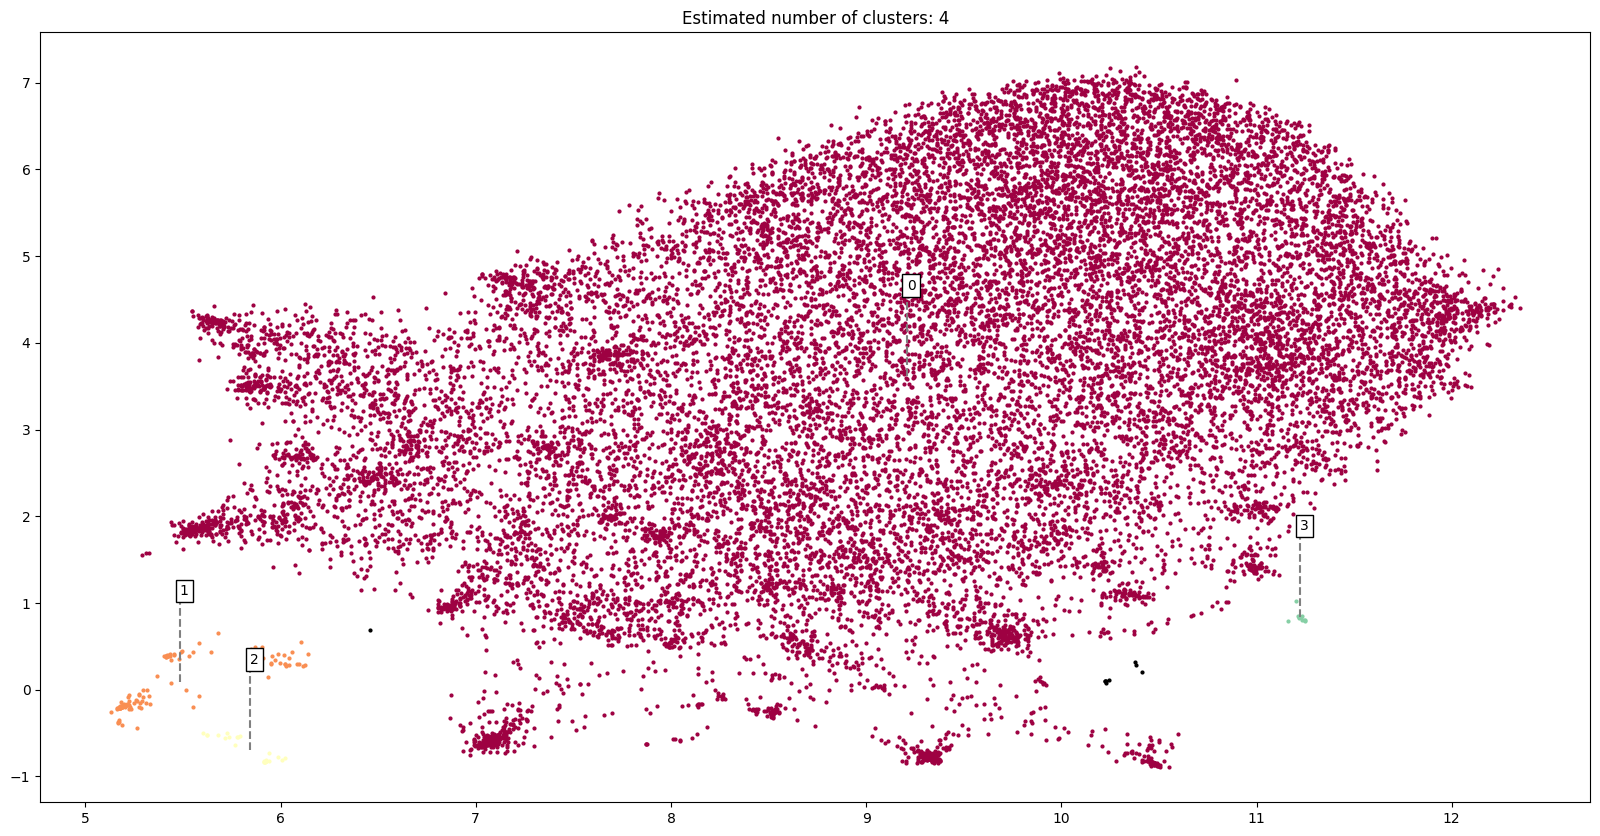

In [35]:
db_labels, db_cosim_df, n_clusters = print_dbscan(umap_embeddings_users, 10)


In [36]:
db_cosim_df

,Cluster #,Cosine Similarity
0,0,0.972246
1,1,0.997176
2,2,0.999553
3,3,0.999970


### test user

In [16]:
TEST_USER_ID = 2

def reccomendation(model, n,  userid, user_item_matrix, userid_to_id):
    recs = model.recommend(userid=userid_to_id[userid],  
                        user_items=csr_matrix(user_item_matrix.loc[userid_to_id[TEST_USER_ID]]).tocsr(),  
                        N=n, 
                        recalculate_user=True,
                        filter_already_liked_items=False)
    return recs[0]

recs = reccomendation(model_als, 10, TEST_USER_ID, user_item_matrix, userid_to_id)
recs

array([ 22, 342, 341, 343,   4, 338,  82,  90,  74,  25], dtype=int32)

In [17]:
user_df = test_df[test_df["user_id"]==TEST_USER_ID]

In [18]:
def calculate_counttable_by_columnname(df, column_name):
        """
        Calculate a count table for a column.
        
        Args:
            df (DataFrame): The DataFrame to calculate the count table for.
            column_name (str): The name of the column to calculate the count table for.
            
        Returns:
            DataFrame: The count table.
        """
        counts = df[column_name].value_counts().reset_index()
        counts.columns = [column_name, 'count']
        counts = counts.sort_values(by='count')
        return counts

calculate_counttable_by_columnname(user_df, 'cart').sort_values(by="count",ascending=False).head(5)

,cart,count
0,383,1
1,87,1
2,382,1
3,23,1
4,100,1


In [19]:
# user_df

### reccomend

In [20]:
k = 30
score_more = 0.99
test_users = test_df.user_id.unique()
test_carts = test_df.cart.unique()
# k = test_carts.shape[0]


In [21]:
def calculate_recommendations_for_user(userid, model, k, user_item_matrix=user_item_matrix, userid_to_id=userid_to_id):

    def reccomendation(model, n,  userid, user_item_matrix, userid_to_id):
        ids, scores = model.recommend(userid=userid_to_id[userid],  
                            user_items=csr_matrix(user_item_matrix.loc[userid_to_id[userid]]).tocsr(),  
                            N=n, 
                            recalculate_user=True,
                            filter_already_liked_items=False)
        return ids, scores
    
    return reccomendation(model, k, userid, user_item_matrix, userid_to_id)


In [22]:
# userid = 1
# userids = 1

# ids, scores = calculate_recommendations_for_user(userid, model, k)

# test_results = pd.DataFrame(columns=['user_id','cart_id','target'])


# for userid in userids:

#     ids, scores = calculate_recommendations_for_user(userid, model, k)

#     for i in range(k):
#         test_results=pd.concat([pd.DataFrame([
#             {   
#                 'user_id': userid, 
#                 'cart_id': cart_id, 
#                 'target': target
#             }]),
#             test_results],ignore_index=True)

In [23]:
test_df

,user_id,order_completed_at,cart
3097178,0,2020-09-02 07:38:25,803
3097179,0,2020-09-02 07:38:25,170
3097180,0,2020-09-02 07:38:25,84
3097181,0,2020-09-02 07:38:25,61
3097182,0,2020-09-02 07:38:25,440
...,...,...,...
3106843,19998,2020-09-02 15:03:23,84
3106844,19998,2020-09-02 15:03:23,798
3106845,19998,2020-09-02 15:03:23,409
3106846,19998,2020-09-02 15:03:23,19


## submit df

In [24]:
submit_df = sample_sumbission.copy()
# submit_df = test_df.copy()

# Разделить каждую ячейку в колонке на два столбца
submit_df[['user_id', 'cart_id']] = submit_df['id'].str.split(';', expand=True)
submit_df['user_id'] = submit_df['user_id'].astype(int)
submit_df['cart_id'] = submit_df['cart_id'].astype(int)

In [25]:
submit_df.head(2)

,id,target,user_id,cart_id
0,0;133,0,0,133
1,0;5,1,0,5


In [26]:
# create reccomended df на основе сабмита

# def create_and_save_df_of_reccomended_lists(submit_df):

#     users_for_predictions = submit_df.user_id.unique()
#     cart_user = submit_df[['user_id', 'cart_id']]

#     list_of_carts = pd.DataFrame(columns=['user_id','carts'])

#     for userid in users_for_predictions:
        
#         carts = cart_user[cart_user["user_id"]==userid].cart_id.to_list()

#         list_of_carts=pd.concat([pd.DataFrame([
#                 {   
#                     'user_id': userid, 
#                     'carts': carts
#                 }]),
#                 list_of_carts],ignore_index=True)
        
#     lists_rec = list_of_carts.sort_values(by='user_id').reset_index(drop=True)
#     lists_rec.to_csv('lists_rec.csv', encoding='utf-8')
#     return lists_rec

# # lists_rec = create_and_save_df_of_reccomended_lists(submit_df)
# lists_rec = pd.read_csv('lists_rec.csv', encoding='utf-8')
# lists_rec.drop(columns=['Unnamed: 0'], inplace=True)
# lists_rec.set_index('user_id', inplace=True)

In [27]:
# lists_rec.head(5)

In [28]:
def calculate_recommendations_for_user(userid, model, k, user_item_matrix=user_item_matrix, userid_to_id=userid_to_id):

    def reccomendation(model, n,  userid, user_item_matrix, userid_to_id):
        ids, scores = model.recommend(userid=userid_to_id[userid],  
                            user_items=csr_matrix(user_item_matrix.loc[userid_to_id[userid]]).tocsr(),  
                            N=n, 
                            recalculate_user=True,
                            filter_already_liked_items=False)
        return ids, scores
    
    return reccomendation(model, k, userid, user_item_matrix, userid_to_id)

def concat_to_df(df, userid, cartid, target):
    df=pd.concat([pd.DataFrame([
                    {   
                        'user_id': userid, 
                        'cart_id': cartid, 
                        'target': target
                    }]),
                    df],ignore_index=True)
    return df


# k = 60
def calculate_recommendations_for_ALL_users(users,model,k=30):
    
    df_test_results = pd.DataFrame(columns=['user_id','cart_id', 'target'])
    for userid in users:
        ids, scores = calculate_recommendations_for_user(userid, model, k)
        for i in range(k):
            df_test_results=concat_to_df(df_test_results, userid , ids[i], scores[i])
        
    df_test_results.to_csv(f'df_test_results_k{k}.csv', encoding='utf-8')
    return df_test_results

In [29]:
users = train_df["user_id"].unique()

df_test_results = calculate_recommendations_for_ALL_users(users,model,k=20)

KeyboardInterrupt: 

In [ ]:
# df_test_results.to_csv(f'df_test_results_k{20}.csv', encoding='utf-8')

In [ ]:
test_df.to_csv(f'test_df.csv', encoding='utf-8')